In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import cv2
import os 

In [2]:
#Create a mask for beam block removal
def circl(x,y, xcen = 396, ycen = 390):
    """
    This functionchecks if a point defined by its x,y cordinates are inside or outside a 
    defined circle with center at xcen, ycen and radius rr
    
    """
    rr = mt.sqrt((x-xcen)**2+(y-ycen)**2)
    if rr>=45:  #rr<=350 and
        return 1.0#True
    else:
        return float('nan')#0.0#False
    
def mask(img,xcen, ycen):
    """
    maask function applies the mask onto the image input
    
    """
    [x,y] = np.shape(img)
    mask = np.zeros([x,y])
    for i in range(x):
        for j in range(y):
            mask[i,j] = pointcheck(i,j)*circl(i,j, xcen, ycen)
    return mask

def pointcheck(xp,yp):
    """
    Point check creats a rectangle on top of the beam block manually and checks if the point is inside it or
    outside
    """
    x1,x2,x3,x4 = [400,400,0,0]
    y1,y2,y3,y4 = [345,400,400,345]
    d1 = (x1-x2)*(yp-y1)-(xp-x1)*(y2-y1)
    d2 = (x2-x3)*(yp-y2)-(xp-x2)*(y3-y2)
    d3 = (x4-x3)*(yp-y3)-(xp-x3)*(y4-y3)
    d4 = (x1-x4)*(yp-y4)-(xp-x4)*(y1-y4)
    if d1<=0 and d2<=0 and d3>=0 and d4>=0:
        return float('nan') #False
    else:
        return 1.0#True
    
def normalize_arr(arr):
    max_value = np.max(arr)
    min_value = np.min(arr)
    out = np.divide(np.subtract(arr,min_value),max_value-min_value)
    return out

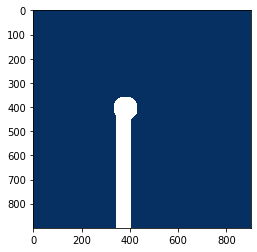

In [3]:
xcen =405 ; ycen = 382
img = np.array(np.zeros([900,900]),dtype = 'uint8')
plt.imshow(mask(img, xcen, ycen), cmap = 'RdBu_r')

(900, 900)


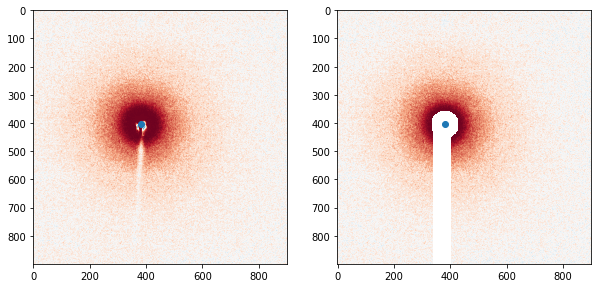

In [12]:
folder = r'D:\PhD Experimental data\Electron diffraction\Analysis'
file =  '2020-02-25_402mW_10us.png'

#'delay_4us.png'

diff_img = cv2.imread(os.path.join(folder,file),0)
print(diff_img.shape)

masked = np.multiply(diff_img, mask(diff_img, xcen, ycen))


plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(diff_img, cmap = 'RdBu_r')
plt.scatter(ycen, xcen)
#plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(masked, cmap = 'RdBu_r')
plt.scatter(ycen, xcen)
#plt.colorbar( )

In [13]:
from diffraction_subfunctions import diffraction_to_azimuthal_avg

s_4us,I_tot = diffraction_to_azimuthal_avg(masked,ycen, xcen)

Electron beam wavelength = 5.3553082697833555e-12 m
Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.944000e-02, 1.833600e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=382.000, y=405.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


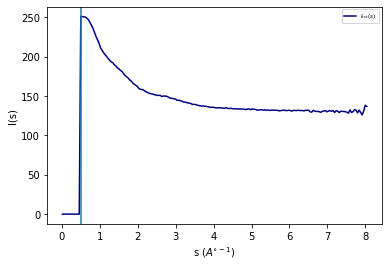

In [14]:
Itot_s2 = np.multiply(I_tot,(np.multiply(s_4us, s_4us)))
plt.plot(s_4us, I_tot, label = '$I_{tot}(s)$', color = 'navy')
#plt.plot(s_4us, Itot_s2, label = '$I_{tot}(s)$', color = 'brown')
plt.xlabel('s ($A^{\circ-1}$)')
plt.ylabel('I(s)')
plt.axvline(0.5)
plt.legend(fontsize = 'xx-small', loc=1)

Electron beam wavelength = 5.3553082697833555e-12 m
Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.944000e-02, 1.833600e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=382.000, y=405.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


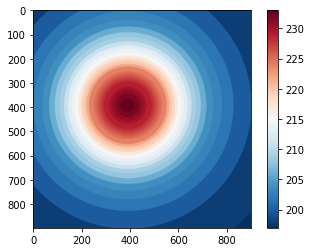

In [15]:
atomic_diff_file = os.path.join(os.getcwd(), 'Iatom_gly_simulated_kirk.png')
I_atom_gly = cv2.imread(atomic_diff_file,0)

_,I_atom = diffraction_to_azimuthal_avg(I_atom_gly,ycen, xcen)

plt.imshow(I_atom_gly, cmap = 'RdBu_r')
plt.colorbar()

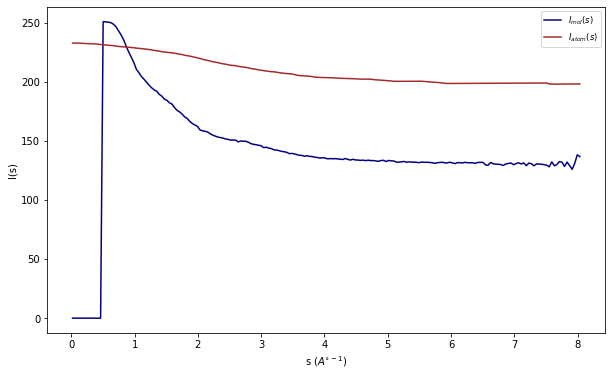

In [16]:
I_atom_new = np.multiply(I_atom,0.7)

plt.figure(figsize=(10, 6))
plt.plot(s_4us, I_tot, label = '$I_{mol}(s)$', color = 'navy')
plt.plot(s_4us, I_atom, label = '$I_{atom}(s)$', color = 'brown')
plt.xlabel('s ($A^{\circ-1}$)')
plt.ylabel('I(s)')
#plt.xlim([1,8])
plt.legend(fontsize = 'small', loc=1)#xx-small

In [17]:
def cut_array(sx,Itot):
    s_cut = []
    I_cut = []
    for s,I in zip(sx,Itot):
        if s>=0.5 and s<=8.0: #
            s_cut.append(s)
            I_cut.append(I)
        else:
            continue
    return s_cut, I_cut

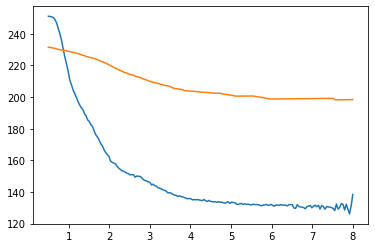

In [18]:
s_cut, I_cut = cut_array(s_4us, I_tot)
_, I_atom_cut = cut_array(s_4us, I_atom)
plt.plot(s_cut,I_cut)
plt.plot(s_cut,I_atom_cut)

In [19]:
#Background being subtracted after fitting the Itot to a cubic polynomial
from scipy.optimize import curve_fit
def fit_poly(x,a,b,c,d):
    x2 = np.multiply(x,x)
    x3 = np.multiply(x2,x)
    y = np.multiply(a, x3)+np.multiply(b, x2)+np.multiply(c,x)+d
    #y = a*x**3+b*x**2+c*x+d
    return y

def power_curve(x,A,n):
    out = np.multiply(np.power(x,n), A)
    return out

popt, pcov = curve_fit(fit_poly, s_cut, I_cut)
power_var, power_covar = curve_fit(power_curve, s_cut, I_cut)
print(popt)

[ -1.03618915  17.13787873 -91.80814717 291.73404653]


In [20]:
bg = fit_poly(s_cut, popt[0],  popt[1], popt[2], popt[3])
bg_power = power_curve(s_cut, power_var[0], power_var[1])

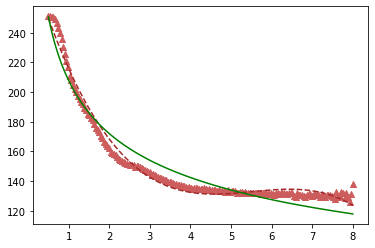

In [21]:
plt.scatter(s_cut, I_cut, marker = '^', color = 'indianred')
plt.plot(s_cut, bg, color = 'brown', ls = '--')
plt.plot(s_cut, bg_power, color ='green')

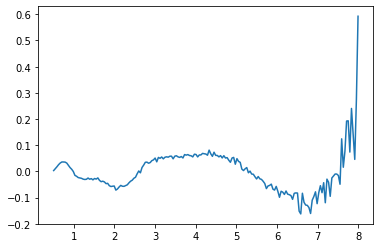

In [22]:
sMs = np.multiply(s_cut, np.divide(I_cut-bg, I_atom_cut))
s2 = np.multiply(s_cut, s_cut)
sMs_s = np.multiply(sMs,s_cut)
#plt.scatter(s_cut, sMs, marker = '^', color = 'indianred')
plt.plot(s_cut, sMs)
#plt.plot(s_cut, sMs_s)

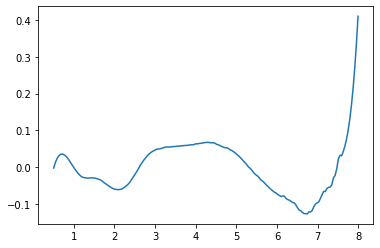

In [23]:
from scipy.signal import savgol_filter
sMs_smooth = savgol_filter(sMs, window_length=21, polyorder=3)
#plt.plot(s_cut, sMs)
plt.plot(s_cut, sMs_smooth)

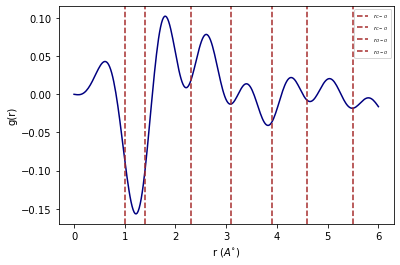

In [24]:
from diffraction_subfunctions import sms_to_mrdf

r, mrdf = sms_to_mrdf(s_cut, sMs)

plt.plot(r, mrdf,color = 'navy')
#plt.axvline(1.108, ls = '--', color = 'brown', label = '$r_{C-O}=1.1674 A^{\circ}$')
plt.axvline(1.0, ls = '--', color = 'brown', label = '$r_{C-O}$')
plt.axvline(1.4, ls = '--', color = 'brown', label = '$r_{C-O}$')
plt.axvline(2.3, ls = '--', color = 'brown', label = '$r_{O-O}$')
plt.axvline(3.1, ls = '--', color = 'brown', label = '$r_{O-O}$')
plt.axvline(4.6, ls='--', color = 'brown')
plt.axvline(3.9, ls='--', color = 'brown')
plt.axvline(5.5, ls='--', color = 'brown')
plt.xlabel('r ($A^{\circ}$)')
plt.ylabel('g(r)')
plt.legend(fontsize = 'xx-small', loc=1)

In [25]:
xyz_file_path = os.getcwd()
xyz_file_name ='Glycerol.xyz'
file = os.path.join(xyz_file_path,xyz_file_name)
from diffraction_subfunctions import diff_image_generator

Iatom_theory, Imol_theory = diff_image_generator(file,ycen, xcen) #, xcen=383, ycen=405

H:\My Documents\GitHub\Electron-diffraction\diffraction_subfunctions.py:200: RuntimeWarning: invalid value encountered in true_divide
  sin_fact = np.divide(np.sin(np.multiply(rij,s)),np.multiply(rij,s))


(899, 899)
Electron beam wavelength = 5.3553082697833555e-12 m
Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.944000e-02, 1.833600e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=382.000, y=405.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


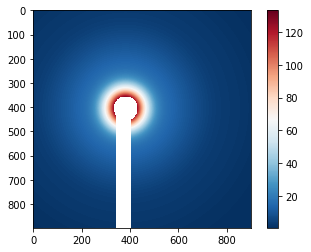

In [26]:
Itot_theory = np.add(Imol_theory, Iatom_theory)
print(Itot_theory.shape)
#Itot_theory = 255.0*normalize_arr(Itot_theory)
masked_theory = np.multiply(Itot_theory, mask(Itot_theory, xcen,ycen))
s_theory,Itot_theory_1d = diffraction_to_azimuthal_avg(masked_theory,ycen, xcen)
#Itot_theory *= 255.0/Itot_theory.max() 
plt.imshow(masked_theory,cmap = 'RdBu_r')
plt.colorbar()

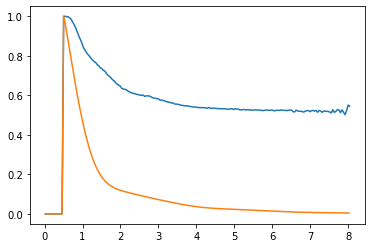

In [27]:
I_tot =normalize_arr(I_tot)
Itot_theory_1d = normalize_arr(Itot_theory_1d)

plt.plot(s_4us,I_tot)
plt.plot(s_theory,Itot_theory_1d)

In [28]:
s_theory, Imol_theory_1d = diffraction_to_azimuthal_avg(Imol_theory, ycen, xcen)
_, Iatom_theory_1d = diffraction_to_azimuthal_avg(Iatom_theory, ycen, xcen)

sMs_theory = np.multiply(s_theory, np.divide(Imol_theory_1d, Iatom_theory_1d))

Electron beam wavelength = 5.3553082697833555e-12 m
Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.944000e-02, 1.833600e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=382.000, y=405.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg
Electron beam wavelength = 5.3553082697833555e-12 m
Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.944000e-02, 1.833600e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=382.000, y=405.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


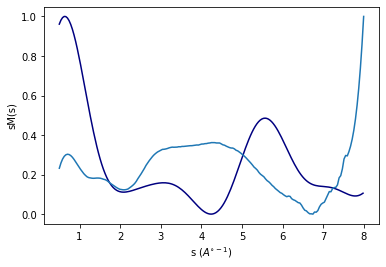

In [29]:
s_cut_theory, sMs_theory_cut = cut_array(s_theory, sMs_theory)

#sMs_theory_cut = sMs_theory_cut/np.linalg.norm(sMs_theory_cut)
#sMs_smooth = sMs_smooth/np.linalg.norm(sMs_smooth)
sMs_theory_cut = normalize_arr(sMs_theory_cut)
sMs_smooth = normalize_arr(sMs_smooth)

plt.plot(s_cut_theory,sMs_theory_cut, color = 'navy')
plt.plot(s_cut, sMs_smooth)
#plt.plot(s_cut, np.multiply(sMs,20))
plt.xlabel('s ($A^{\circ-1}$)')
plt.ylabel('sM(s)')
plt.savefig('sM(s)_ccl4.png', bbox_inches = 'tight')

In [30]:
r_theory, mrdf_theory = sms_to_mrdf(s_theory, sMs_theory)
r_theory_cut, mrdf_theory_cut = sms_to_mrdf(s_cut_theory, sMs_theory_cut)

#normalize        
#mrdf = mrdf/np.linalg.norm(mrdf)
#mrdf_theory_cut = mrdf_theory_cut/np.linalg.norm(mrdf_theory_cut)

mrdf = normalize_arr(mrdf)
mrdf_theory_cut = normalize_arr(mrdf_theory_cut)
mrdf_theory = normalize_arr(mrdf_theory)

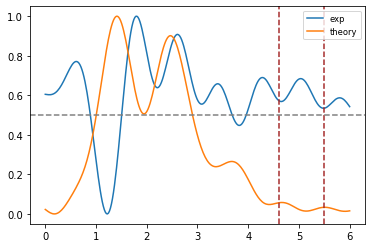

In [31]:
plt.plot(r, mrdf, label = 'exp')
plt.plot(r_theory, mrdf_theory, label = 'theory')
#plt.plot(r_theory_cut, mrdf_theory_cut, label='theory_cut')
plt.legend(fontsize = 'small', loc=1)
plt.axvline(4.6, ls='--', color = 'brown')
plt.axvline(5.5, ls='--', color = 'brown')
plt.axhline(0.5, ls = '--', color ='gray')